# Constants

In [25]:
ROOT_PATH = "/kaggle/input"
DATA_PATH = "/kaggle/input/monusac-pannuke-consep"

In [26]:
DATASET = "PanNuke" # MoNuSAC, PanNuke, CoNSeP_Tiled
NUM_CLASSES = 6 # 5, 6, 8
BATCH_SIZE = 64

# Data Loading

In [27]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Root dataset directory, e.g., "MoNuSAC"
            split (str): One of 'train', 'val', 'test'
            image_transform (callable, optional): Transform applied only to image
        """
        self.split_dir = os.path.join(root_dir, split)
        self.sample_dirs = sorted([
            os.path.join(self.split_dir, d)
            for d in os.listdir(self.split_dir)
            if os.path.isdir(os.path.join(self.split_dir, d))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]

        image = np.load(os.path.join(sample_dir, "image.npy"))  # HWC
        mask = np.load(os.path.join(sample_dir, "mask.npy"))    # HW
        h_map = np.load(os.path.join(sample_dir, "h_map.npy"))  # HW
        v_map = np.load(os.path.join(sample_dir, "v_map.npy"))  # HW

        h_map = (h_map.astype(np.float32) / 127.5) - 1.0
        v_map = (v_map.astype(np.float32) / 127.5) - 1.0

        if self.transform:
            image = self.transform(image)

        return image, \
                torch.from_numpy(mask).long(), \
                torch.from_numpy(h_map).float(), \
                torch.from_numpy(v_map).float()

In [28]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts HWC to CHW and scales to [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # example: scale to [-1, 1]
])

dataset_path = os.path.join(DATA_PATH, DATASET)

train_dataset = SegmentationDataset(dataset_path, split="train", transform=transform)
val_dataset = SegmentationDataset(dataset_path, split="val", transform=transform)
test_dataset = SegmentationDataset(dataset_path, split="test", transform=transform)

In [29]:
from torch.utils.data import Dataset, DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [30]:
print("First fold:", len(train_dataloader))
print("Second fold:", len(val_dataloader))
print("Third fold:", len(test_dataloader))

First fold: 42
Second fold: 40
Third fold: 43


In [31]:
image, mask, h_map, v_map = next(iter(train_dataloader))
print(image.shape)
print(mask.shape)
print(h_map.shape)
print(v_map.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])


# Graph HoVerNet

In [32]:
!pip install -U segmentation-models-pytorch torch-geometric scikit-image

In [33]:
def get_sinusoidal_encoding(coords, num_freqs=64):
    """
    coords: (N, 2) integer tensor with (y, x) positions
    returns: (N, 4 * num_freqs) tensor of sinusoidal embeddings
    """
    device = coords.device
    N = coords.size(0)
    freqs = torch.arange(num_freqs, dtype=torch.float32, device=device)  # [0, 1, ..., num_freqs-1]
    freqs = 1.0 / (10000 ** (freqs / num_freqs))  # shape: [num_freqs]

    pos_y = coords[:, 0].unsqueeze(1).float()  # [N, 1]
    pos_x = coords[:, 1].unsqueeze(1).float()  # [N, 1]

    y_embed = pos_y * freqs  # [N, num_freqs]
    x_embed = pos_x * freqs

    sin_cos_y = torch.cat([y_embed.sin(), y_embed.cos()], dim=1)
    sin_cos_x = torch.cat([x_embed.sin(), x_embed.cos()], dim=1)
    return torch.cat([sin_cos_y, sin_cos_x], dim=1)  # [N, 4 * num_freqs]

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from sklearn.neighbors import NearestNeighbors
import numpy as np

from torch_geometric.nn import GENConv, LayerNorm, Linear


class GraphBranch(nn.Module):
    """Node-level GNN classifier using 3-layer GENConv with edge_attr"""
    def __init__(self, in_channels=512, hidden_channels=128, edge_dim=256, num_layers=3, num_classes=5, dropout=0.1):
        super().__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        self.convs.append(GENConv(in_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
            self.norms.append(LayerNorm(hidden_channels))

        self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        self.classifier = nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            LayerNorm(hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            Linear(hidden_channels // 2, num_classes)
        )

        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = self.convs[0](x, edge_index, edge_attr)
        x = self.norms[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for i in range(1, len(self.convs) - 1):
            residual = x
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.norms[i](x)
            x = F.relu(x + residual)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index, edge_attr)
        x = self.norms[-1](x)
        x = F.relu(x)

        node_pred = self.classifier(x)
        return node_pred, x  # logits, final embeddings

class GraphHoverNet(nn.Module):
    def __init__(self, num_classes=6, encoder_name='resnet34', encoder_weights='imagenet', 
                 use_graph=True, k_neighbors=8, graph_feature_dim=288):
        super().__init__()
        self.use_graph = use_graph
        self.k_neighbors = k_neighbors

        # Shared encoder
        self.shared_encoder = smp.encoders.get_encoder(encoder_name, in_channels=3, depth=5, weights=encoder_weights)

        # Use shared encoder in all heads
        self.model_np = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_hv = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_nc = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=num_classes, activation=None)

        self.model_np.encoder = self.shared_encoder
        self.model_hv.encoder = self.shared_encoder
        self.model_nc.encoder = self.shared_encoder

        if self.use_graph:
            self.graph_branch = GraphBranch(in_channels=graph_feature_dim,
                                            num_layers=2, num_classes=num_classes)

    def set_stage(self, stage):
        if stage == 'pretrain':
            self.use_graph = False

            for m in [self.model_np, self.model_hv, self.model_nc]:
                    for p in m.parameters():
                        p.requires_grad = True

        elif stage == 'finetune':
            self.use_graph = True

            for p in self.shared_encoder.parameters():
                p.requires_grad = False

            # Unfreeze everything else
            for m in [self.model_np.decoder, self.model_np.segmentation_head,
                      self.model_hv.decoder, self.model_hv.segmentation_head,
                      self.model_nc.decoder, self.model_nc.segmentation_head,
                      self.graph_branch]:
                for p in m.parameters():
                    p.requires_grad = True
                    
    def extract_nucleus_centroids(self, np_pred, hv_pred, threshold=0.5):
        batch_size = np_pred.shape[0]
        centroids_list = []
        for b in range(batch_size):
            prob_map = torch.sigmoid(np_pred[b, 1])
            mask = prob_map > threshold
            if mask.sum() == 0:
                centroids_list.append(torch.empty(0, 2).to(np_pred.device))
                continue
            coords = torch.nonzero(mask, as_tuple=False).float()
            if coords.shape[0] > 500:
                probs = prob_map[mask]
                _, top_indices = torch.topk(probs, 500)
                coords = coords[top_indices]
            centroids_list.append(coords)
        return centroids_list

    def build_graph(self, centroids, features):
        if centroids.shape[0] == 0:
            return torch.empty(2, 0).long().to(centroids.device)
        centroids_np = centroids.cpu().numpy()
        if centroids_np.shape[0] <= self.k_neighbors:
            n = centroids_np.shape[0]
            edges = []
            for i in range(n):
                for j in range(i + 1, n):
                    edges.extend([[i, j], [j, i]])
            if len(edges) == 0:
                return torch.empty(2, 0).long().to(centroids.device)
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        else:
            nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, centroids_np.shape[0]))
            nbrs.fit(centroids_np)
            distances, indices = nbrs.kneighbors(centroids_np)
            edges = []
            for i in range(indices.shape[0]):
                for j in range(1, indices.shape[1]):
                    edges.extend([[i, indices[i, j]], [indices[i, j], i]])
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        return edge_index

    def forward(self, x):
        batch_size = x.shape[0]
        out_np = self.model_np(x)
        out_hv = self.model_hv(x)
        out_nc = self.model_nc(x)
        if not self.use_graph:
            return out_np, out_hv, out_nc, None, None

        out_gc = None
        graph_enhanced_nc = out_nc.clone()
        encoder_feats = self.shared_encoder(x)
        encoder_features = F.interpolate(encoder_feats[-2], size=(255, 255), mode="bilinear", align_corners=False)

        all_centroids = []
        all_out_gc = []
        
        for b in range(batch_size):
            centroids = self.extract_nucleus_centroids(out_np[b:b+1], out_hv[b:b+1], threshold=0.3)[0]
            if centroids.shape[0] == 0:
                continue
            h, w = encoder_features.shape[2], encoder_features.shape[3]
            centroid_coords = centroids.long()
            centroid_coords[:, 0] = torch.clamp(centroid_coords[:, 0], 0, h - 1)
            centroid_coords[:, 1] = torch.clamp(centroid_coords[:, 1], 0, w - 1)
            node_feats = encoder_features[b, :, centroid_coords[:, 0], centroid_coords[:, 1]].t()
            
            # Generate sinusoidal positional encodings
            pos_enc = get_sinusoidal_encoding(centroid_coords, num_freqs=8)  # [N, 32]
            
            # Concatenate encoder + positional features
            node_features = torch.cat([node_feats, pos_enc], dim=1)  # [N, C + 32]

            edge_index = self.build_graph(centroids, node_features)

            mid = ((centroid_coords[edge_index[0]] + centroid_coords[edge_index[1]]) / 2).long()
            mid[:, 0] = mid[:, 0].clamp(0, 254)
            mid[:, 1] = mid[:, 1].clamp(0, 254)
            
            # Edge attributes from midpoints
            edge_attr = encoder_features[b][:, mid[:, 0], mid[:, 1]].t()  # [num_edges, C]
            if edge_index.shape[1] > 0:
                out_gc, _ = self.graph_branch(node_features, edge_index, edge_attr)
                all_centroids.append(torch.cat([centroid_coords, torch.full((centroid_coords.shape[0], 1), b, device=x.device)], dim=1))  # (N, 3): (y, x, batch_id)
                all_out_gc.append(out_gc)

        if all_centroids:
            centroid_coords = torch.cat(all_centroids, dim=0)  # (sum(N), 3)
            out_gc = torch.cat(all_out_gc, dim=0)              # (sum(N), C)
        else:
            centroid_coords = torch.empty(0, 3, device=x.device)
            out_gc = None

        return out_np, out_hv, out_nc, centroid_coords, out_gc

    def print_model_stats(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    
        def count_params(module):
            return sum(p.numel() for p in module.parameters())
    
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Shared encoder parameters: {count_params(self.shared_encoder):,}")
        print(f"NP head parameters (excluding encoder): {count_params(self.model_np.decoder) + count_params(self.model_np.segmentation_head):,}")
        print(f"HV head parameters (excluding encoder): {count_params(self.model_hv.decoder) + count_params(self.model_hv.segmentation_head):,}")
        print(f"NC head parameters (excluding encoder): {count_params(self.model_nc.decoder) + count_params(self.model_nc.segmentation_head):,}")
        print(f"Graph branch parameters: {count_params(self.graph_branch):,}")

In [35]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class DiceCoeff(nn.Module):
    def __init__(self, ignore_index: int = None, smooth: float = 1e-7):
        super().__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        inputs: (N, C, ...) — raw logits
        targets: (N, ...) — class indices
        """
        inputs = F.softmax(inputs, dim=1)  # Convert to probabilities
        N, C = inputs.shape[:2]
        spatial_dims = inputs.shape[2:]  # Arbitrary spatial shape

        # One-hot encode targets to (N, C, ...)
        targets_onehot = F.one_hot(targets, num_classes=C).permute(0, -1, *range(1, targets.ndim)).float()

        # Flatten all dimensions except batch and channel
        inputs_flat = inputs.view(N, C, -1)
        targets_flat = targets_onehot.view(N, C, -1)

        # Optional: handle ignore index
        if self.ignore_index is not None:
            mask = targets != self.ignore_index  # shape (N, ...)
            mask = mask.view(N, -1).unsqueeze(1)  # (N, 1, num_voxels)
            inputs_flat = inputs_flat * mask
            targets_flat = targets_flat * mask

        intersection = (inputs_flat * targets_flat).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (
            inputs_flat.sum(dim=2) + targets_flat.sum(dim=2) + self.smooth
        )
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', ignore_index=-100):
        """
        Multi-class focal loss implementation.
        Args:
            alpha (float): balancing factor for classes.
            gamma (float): focusing parameter.
            reduction (str): 'mean', 'sum' or 'none'.
            ignore_index (int, optional): class index to ignore in loss.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
            
class LaplacianLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a 3x3 Laplacian kernel
        kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32).view(1, 1, 3, 3)
        self.register_buffer('kernel', kernel)

    def forward(self, pred: torch.Tensor):
        """
        Args:
            pred: (N, 1, H, W) tensor on any device
        Returns:
            Laplacian smoothness loss (scalar)
        """
        # Move kernel to the same device as pred
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)
        kernel = self.kernel.to(pred.device)
        pred_lap = F.conv2d(pred, kernel, padding=1)
        return torch.mean(torch.abs(pred_lap))

class _NPBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super(_NPBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.alpha = alpha
        self.beta = beta

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss


class _HVBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super().__init__()
        self.laplacian = LaplacianLoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits: torch.Tensor, h_grads: torch.Tensor, v_grads: torch.Tensor):
        hl = logits[:, 0, :, :]
        vl = logits[:, 1, :, :]

        mse_loss = F.mse_loss(hl, h_grads) + F.mse_loss(vl, v_grads)
        laplacian_loss = self.laplacian(hl) + self.laplacian(vl)

        return self.alpha * mse_loss + self.beta * laplacian_loss

class _GCBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1, gamma=1):
        super(_GCBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.focal_loss = FocalLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        focal_loss = self.focal_loss(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss + self.gamma * focal_loss
        
class HoverLoss(nn.Module):
    def __init__(self):
        super(HoverLoss, self).__init__()
        self.np_loss = _NPBranchLoss(0.75, 0.25)
        self.hv_loss = _HVBranchLoss(0.5, 0.5)
        self.nc_loss = _NPBranchLoss(0.75, 0.25)
        self.gc_loss = _GCBranchLoss(1, 1, 1)

    def forward(self, np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                gc_logits=None, gc_targets=None,
                weights=(1, 1, 1, 1)) -> torch.Tensor:

        loss_np = self.np_loss(np_logits, np_targets) * weights[0]
        loss_hv = self.hv_loss(hv_logits, h_grads, v_grads) * weights[1]
        loss_nc = self.nc_loss(nc_logits, nc_targets) * weights[2]

        if gc_logits is not None and gc_targets is not None and gc_logits.numel() > 0:
            loss_gc = self.gc_loss(gc_logits, gc_targets) * weights[3]
        else:
            loss_gc = torch.tensor(0.0, device=np_logits.device)

        return loss_np + loss_hv + loss_nc + loss_gc

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphHoverNet(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = HoverLoss()

In [37]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [38]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device, return_centroids=False, nr_types=6):
    """
    Postprocess HoVerNet outputs to obtain instance segmentation and class predictions.

    Args:
        np_logits (Tensor): [B, 1, H, W] - nuclei presence logits.
        hv_logits (Tensor): [B, 2, H, W] - horizontal and vertical offset logits.
        nc_logits (Tensor): [B, C, H, W] - nuclear classification logits.
        device (torch.device): Device for output tensors.
        return_centroids (bool): Placeholder for future use.
        nr_types (int): Number of nuclear classes.

    Returns:
        Tensor: [B, H, W] instance segmentation with class IDs.
    """
    def process(pred_map: torch.Tensor) -> torch.Tensor:
        """
        Process a single HoVerNet prediction map to obtain instance-wise segmentation with class labels.

        Args:
            pred_map (Tensor): [H, W, 4] - np_mask, h_map, v_map, class_map

        Returns:
            Tensor: [H, W] with instance-wise majority-vote class labels.
        """
        pred_map = pred_map.cpu().numpy()
        np_mask = pred_map[:, :, 0] > 0.5
        h_map = pred_map[:, :, 1]
        v_map = pred_map[:, :, 2]
        class_map = pred_map[:, :, 3].astype(np.int32)

        # --- Energy landscape: gradient magnitude ---
        dx = cv2.Sobel(h_map, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(v_map, cv2.CV_64F, 0, 1, ksize=3)
        energy = np.sqrt(dx ** 2 + dy ** 2)

        energy = (energy - energy.min()) / (energy.max() - energy.min() + 1e-8)
        energy = 1.0 - energy  # Nuclei centers become minima

        # --- Marker-based watershed ---
        distance = ndi.distance_transform_edt(np_mask)
        coords = peak_local_max(distance, labels=np_mask, footprint=np.ones((3, 3)), exclude_border=False)
        markers = np.zeros_like(np_mask, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, start=1):
            markers[y, x] = idx

        instance_map = watershed(energy, markers=markers, mask=np_mask)

        # --- Majority vote for class per instance ---
        type_map = np.zeros_like(instance_map, dtype=np.int32)
        for inst_id in range(1, instance_map.max() + 1):
            mask = instance_map == inst_id
            class_ids, counts = np.unique(class_map[mask], return_counts=True)
            if len(class_ids) > 0:
                majority_class = class_ids[np.argmax(counts)]
                type_map[mask] = majority_class

        return torch.from_numpy(type_map).long().to(device)

    # --- Batch processing ---
    batch_size = np_logits.shape[0]
    np_pred = torch.argmax(np_logits, dim=1, keepdim=True)  # [B, 1, H, W]
    nc_pred = torch.argmax(nc_logits, dim=1, keepdim=True)  # [B, 1, H, W]

    results = []
    for i in range(batch_size):
        nuclei_presence = np_pred[i].permute(1, 2, 0)           # [H, W, 1]
        h_map = hv_logits[i, 0:1].permute(1, 2, 0)              # [H, W, 1]
        v_map = hv_logits[i, 1:2].permute(1, 2, 0)              # [H, W, 1]
        class_map = nc_pred[i].permute(1, 2, 0) if nr_types else torch.zeros_like(h_map)

        pred_map = torch.cat([nuclei_presence, h_map, v_map, class_map], dim=-1)  # [H, W, 4]
        instance_seg = process(pred_map)  # [H, W]
        results.append(instance_seg)

    return torch.stack(results)  # [B, H, W]

In [39]:
def get_node_labels_from_coords(centroid_coords, type_maps):
    """
    Args:
        centroid_coords: (N, 3) tensor, (y, x, batch_id)
        type_maps: (B, H, W) tensor of type labels

    Returns:
        labels: (N,) long tensor
    """
    y = centroid_coords[:, 0].clamp(0, type_maps.shape[1] - 1)
    x = centroid_coords[:, 1].clamp(0, type_maps.shape[2] - 1)
    b = centroid_coords[:, 2].clamp(0, type_maps.shape[0] - 1)

    return type_maps[b, y, x]

In [40]:
model.set_stage("pretrain")

with torch.no_grad():
    images, masks, h_grads, v_grads = next(iter(train_dataloader))
    images = images.to(device)
    masks = masks.to(device).long()
    h_grads = h_grads.to(device)
    v_grads = v_grads.to(device)

    nc_targets = masks
    np_targets = (nc_targets > 0).long()

    np_logits, hv_logits, nc_logits, centroids, gc_logits = model(images)

    if gc_logits is not None and centroids.shape[0] > 0:
        node_labels = get_node_labels_from_coords(centroids, nc_targets)
        valid = node_labels != 0
    
        if valid.any():
            graph_loss_inputs = (gc_logits[valid], node_labels[valid])
        else:
            # No valid labels — skip graph loss
            graph_loss_inputs = (None, None)
    else:
        # No graph predictions — skip graph loss
        graph_loss_inputs = (None, None)
    
    loss = criterion(
        np_logits, np_targets,
        hv_logits, h_grads, v_grads,
        nc_logits, nc_targets,
        *graph_loss_inputs
    )
    
    # # Evaluate
    nc_pred = torch.argmax(nc_logits, dim=1)
    # iou = compute_multiclass_iou(pred_inst, nc_targets, num_classes=6)
    # pq = compute_multiclass_pq(pred_inst, nc_targets, num_classes=6)

    # Postprocess
    postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)

    tp, fp, fn, tn = smp.metrics.get_stats(
        postprocessed_pred, nc_targets,
        mode='multiclass',
        num_classes=NUM_CLASSES
    )

    iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)
    
    print("Loss:", loss)
    print("AJI:", iou_per_class.mean())
    print("PQ:", pq_per_class.mean())
    print("Average F1:", f1_per_class.mean())
    print("F1 Per Class:", f1_per_class)

Loss: tensor(4.8599, device='cuda:0')
AJI: tensor(0.0200)
PQ: tensor(0.0260)
Average F1: tensor(0.0369)
F1 Per Class: tensor([0.0773, 0.0420, 0.0434, 0.0000, 0.0216])


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from skimage.color import label2rgb

def visualize_hovernet_output(pred_inst, inst_info=None, show_types=True):
    """
    Visualize the instance segmentation map with optional type labels and centroids.

    Args:
        pred_inst (np.ndarray): [H, W] array of instance IDs.
        inst_info (dict): {inst_id: {'centroid': (x, y), 'type': int}}, optional.
        show_types (bool): If True, display type labels at centroid positions.
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(pred_inst, cmap="jet")
    ax.set_title("Instance Segmentation")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

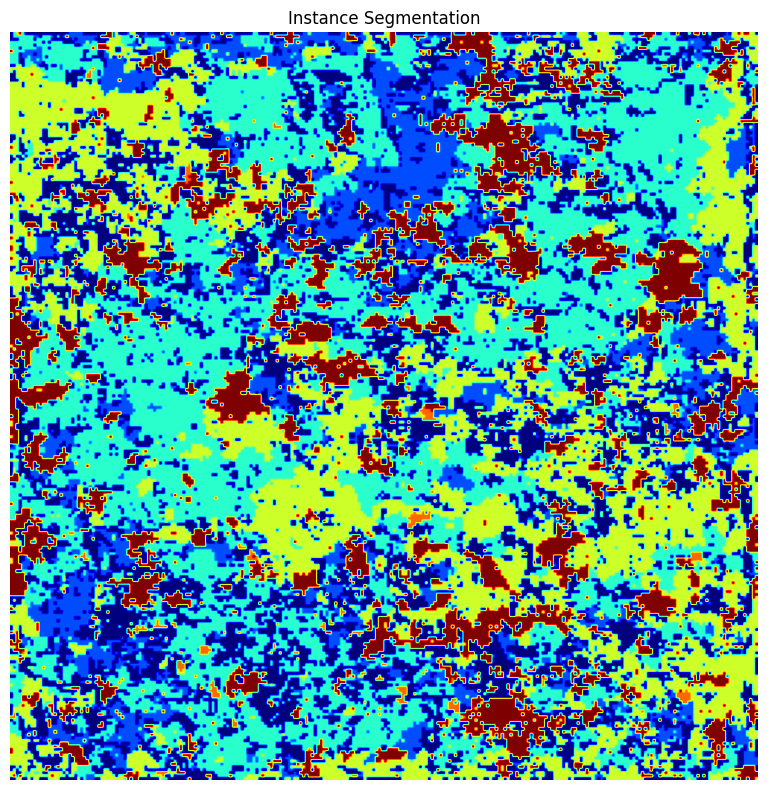

In [42]:
visualize_hovernet_output(postprocessed_pred.cpu().numpy()[0])

In [43]:
from tqdm import tqdm
import torch
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp

def train_one_epoch(model, dataloader, optimizer, criterion, device, num_classes=5):
    model.train()
    scaler = GradScaler()

    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Training", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        optimizer.zero_grad()

        with autocast(device.type):
            np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

            # Get graph branch labels
            if gc_logits is not None and centroids.shape[0] > 0:
                gc_targets = get_node_labels_from_coords(centroids, nc_targets)
                valid = gc_targets != 0
                if valid.any():
                    gc_input = (gc_logits[valid], gc_targets[valid])
                else:
                    gc_input = (None, None)
            else:
                gc_input = (None, None)

            # Compute total loss
            loss = criterion(
                np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                *gc_input
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            nc_pred = torch.argmax(nc_logits, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(
                nc_pred, nc_targets,
                mode='multiclass',
                num_classes=num_classes  # assuming class 0 is background
            )

            iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate per class
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [44]:
@torch.no_grad()
def validate(model, dataloader, criterion, device, num_classes=5, post_process=False):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Validation", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

        # Process graph branch if available
        if gc_logits is not None and centroids.shape[0] > 0:
            gc_targets = get_node_labels_from_coords(centroids, nc_targets)
            valid = gc_targets != 0
            if valid.any():
                gc_input = (gc_logits[valid], gc_targets[valid])
            else:
                gc_input = (None, None)
        else:
            gc_input = (None, None)

        # Compute total loss
        loss = criterion(
            np_logits, np_targets,
            hv_logits, h_grads, v_grads,
            nc_logits, nc_targets,
            *gc_input
        )

        if post_process:
            nc_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        else:
            nc_pred = torch.argmax(nc_logits, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            nc_pred, nc_targets,
            mode='multiclass',
            num_classes=num_classes   # if class 0 is background
        )

        iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)  # [1:] to skip background
        f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
        pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.amp import GradScaler, autocast

def train(model, criterion, train_loader, val_loader, device, 
          epochs=20, lr=1e-4, num_classes=5, patience=5):
    
    def train_loop(stage_name, use_graph, start_epoch=1, lr=lr):
        nonlocal best_val_pq
        nonlocal epochs_no_improve

        best_val_pq = -float('inf')
        epochs_no_improve = 0
        
        print(f"\n=== Starting {stage_name} phase ===")
        model.set_stage('pretrain' if not use_graph else 'finetune')

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            current_epoch = start_epoch + epoch
            print(f"\nEpoch {current_epoch}/{start_epoch + epochs - 1} [{stage_name}]")
            
            train_loss, train_iou, train_f1, train_pq, train_f1_per_class = train_one_epoch(
                model, train_loader, optimizer, criterion, device, num_classes)
            val_loss, val_iou, val_f1, val_pq, val_f1_per_class = validate(
                model, val_loader, criterion, device, num_classes)

            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_ious.append(train_iou)
            val_ious.append(val_iou)
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)
            train_pqs.append(train_pq)
            val_pqs.append(val_pq)
    
            print(f"Train Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | F1: {train_f1:.4f} | PQ: {train_pq:.4f}")
            print(f"Val   Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f} | PQ: {val_pq:.4f}")
            
            # Print per-class F1 (excluding background class 0)
            train_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(train_f1_per_class[1:]))
            val_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(val_f1_per_class[1:]))
            print(f"Train F1 per class: {train_f1_str}")
            print(f"Val   F1 per class: {val_f1_str}")
    
            if val_pq > best_val_pq:
                best_val_pq = val_pq
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"best_hovernet_{stage_name}.pt")
                print("Saved best model (based on PQ).")
            else:
                epochs_no_improve += 1
                print(f"No improvement in PQ for {epochs_no_improve} epoch(s).")
    
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement in PQ.")
                break
        
        return current_epoch + 1

    # Track metrics
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_f1s, val_f1s = [], []
    train_pqs, val_pqs = [], []

    best_val_pq = -float('inf')
    epochs_no_improve = 0

    next_epoch = train_loop(stage_name='pretrain', use_graph=False, start_epoch=1)
    next_epoch = train_loop(stage_name='finetune', use_graph=True, start_epoch=next_epoch, lr=1e-2)

    print(f"\nTraining complete. Best Val PQ: {best_val_pq:.4f}")

    # === Plotting ===
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs_range, train_ious, label='Train IoU')
    plt.plot(epochs_range, val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('IoU over Epochs')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs_range, train_f1s, label='Train F1')
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 over Epochs')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs_range, train_pqs, label='Train PQ')
    plt.plot(epochs_range, val_pqs, label='Val PQ')
    plt.xlabel('Epoch')
    plt.ylabel('PQ')
    plt.title('PQ over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Save metrics ===
    metrics_df = pd.DataFrame({
        "Epoch": list(epochs_range),
        "Train Loss": train_losses,
        "Val Loss": val_losses,
        "Train IoU": train_ious,
        "Val IoU": val_ious,
        "Train F1": train_f1s,
        "Val F1": val_f1s,
        "Train PQ": train_pqs,
        "Val PQ": val_pqs,
    })
    metrics_df.to_csv("training_metrics.csv", index=False)
    print("Saved training metrics to training_metrics.csv")

In [46]:
@torch.no_grad()
def final_evaluate(model, test_loader, criterion, device, stage_name, num_classes=6):
    model.load_state_dict(torch.load(f"best_hovernet_{stage_name}.pt"))
    model.set_stage(stage_name)
    
    test_loss, test_iou, test_f1, test_pq, f1_per_class = validate(
        model, test_loader, criterion, device, num_classes, post_process=True
    )
    
    print(f"\nFinal Test | Loss: {test_loss:.4f} | IoU: {test_iou:.4f} | F1: {test_f1:.4f} | PQ: {test_pq:.4f}")
    print("F1 per class (excluding background):", f1_per_class)

In [47]:
import gc

gc.collect()
torch.cuda.empty_cache()


=== Starting pretrain phase ===

Epoch 1/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:19<00:00,  2.03it/s, f1=0.081, f1_per_class=[0.0045, 0.0004, 0.0035, 0.0, 0.0001], iou=0.0528, loss=2, pq=0.0637]       


Train Loss: 2.7733 | IoU: 0.0395 | F1: 0.0631 | PQ: 0.0484
Val   Loss: 1.9999 | IoU: 0.0528 | F1: 0.0810 | PQ: 0.0637
Train F1 per class: Class 1: 0.2141 | Class 2: 0.0342 | Class 3: 0.0475 | Class 4: 0.0013 | Class 5: 0.0186
Val   F1 per class: Class 1: 0.2483 | Class 2: 0.0671 | Class 3: 0.0632 | Class 4: 0.0063 | Class 5: 0.0201
Saved best model (based on PQ).

Epoch 2/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s, f1=0.106, f1_per_class=[0.0051, 0.0009, 0.0055, 0.0, 0.0002], iou=0.0705, loss=1.65, pq=0.0843]    


Train Loss: 1.7421 | IoU: 0.0667 | F1: 0.0995 | PQ: 0.0796
Val   Loss: 1.6469 | IoU: 0.0705 | F1: 0.1056 | PQ: 0.0843
Train F1 per class: Class 1: 0.3087 | Class 2: 0.0637 | Class 3: 0.1039 | Class 4: 0.0012 | Class 5: 0.0202
Val   F1 per class: Class 1: 0.2911 | Class 2: 0.1058 | Class 3: 0.1073 | Class 4: 0.0031 | Class 5: 0.0206
Saved best model (based on PQ).

Epoch 3/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s, f1=0.109, f1_per_class=[0.0051, 0.0006, 0.0042, 0.0, 0.0002], iou=0.0752, loss=1.41, pq=0.0884]   


Train Loss: 1.5155 | IoU: 0.0737 | F1: 0.1084 | PQ: 0.0874
Val   Loss: 1.4140 | IoU: 0.0752 | F1: 0.1088 | PQ: 0.0884
Train F1 per class: Class 1: 0.3258 | Class 2: 0.0831 | Class 3: 0.1023 | Class 4: 0.0023 | Class 5: 0.0286
Val   F1 per class: Class 1: 0.2994 | Class 2: 0.1011 | Class 3: 0.0858 | Class 4: 0.0203 | Class 5: 0.0373
Saved best model (based on PQ).

Epoch 4/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s, f1=0.265, f1_per_class=[0.0057, 0.0012, 0.0047, 0.0185, 0.0003], iou=0.228, loss=1.23, pq=0.243]


Train Loss: 1.3079 | IoU: 0.1187 | F1: 0.1547 | PQ: 0.1332
Val   Loss: 1.2330 | IoU: 0.2276 | F1: 0.2645 | PQ: 0.2426
Train F1 per class: Class 1: 0.3318 | Class 2: 0.1355 | Class 3: 0.0773 | Class 4: 0.1853 | Class 5: 0.0435
Val   F1 per class: Class 1: 0.3194 | Class 2: 0.1682 | Class 3: 0.0881 | Class 4: 0.6908 | Class 5: 0.0563
Saved best model (based on PQ).

Epoch 5/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, f1=0.358, f1_per_class=[0.0068, 0.0084, 0.0045, 0.025, 0.0005], iou=0.322, loss=1.07, pq=0.337] 


Train Loss: 1.1336 | IoU: 0.2903 | F1: 0.3276 | PQ: 0.3059
Val   Loss: 1.0694 | IoU: 0.3216 | F1: 0.3582 | PQ: 0.3370
Train F1 per class: Class 1: 0.3725 | Class 2: 0.2432 | Class 3: 0.0849 | Class 4: 0.8713 | Class 5: 0.0661
Val   F1 per class: Class 1: 0.3607 | Class 2: 0.3017 | Class 3: 0.0893 | Class 4: 0.9609 | Class 5: 0.0783
Saved best model (based on PQ).

Epoch 6/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.381, f1_per_class=[0.0099, 0.0092, 0.0054, 0.025, 0.0006], iou=0.345, loss=0.978, pq=0.36]  


Train Loss: 1.0100 | IoU: 0.3364 | F1: 0.3734 | PQ: 0.3522
Val   Loss: 0.9778 | IoU: 0.3446 | F1: 0.3813 | PQ: 0.3601
Train F1 per class: Class 1: 0.4124 | Class 2: 0.3258 | Class 3: 0.0974 | Class 4: 0.9483 | Class 5: 0.0830
Val   F1 per class: Class 1: 0.3835 | Class 2: 0.3481 | Class 3: 0.1142 | Class 4: 0.9719 | Class 5: 0.0888
Saved best model (based on PQ).

Epoch 7/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.406, f1_per_class=[0.0124, 0.0095, 0.0089, 0.025, 0.0005], iou=0.364, loss=0.89, pq=0.382]  


Train Loss: 0.9247 | IoU: 0.3604 | F1: 0.4001 | PQ: 0.3774
Val   Loss: 0.8905 | IoU: 0.3641 | F1: 0.4057 | PQ: 0.3816
Train F1 per class: Class 1: 0.4440 | Class 2: 0.3617 | Class 3: 0.1428 | Class 4: 0.9665 | Class 5: 0.0853
Val   F1 per class: Class 1: 0.4046 | Class 2: 0.3936 | Class 3: 0.1768 | Class 4: 0.9727 | Class 5: 0.0807
Saved best model (based on PQ).

Epoch 8/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.413, f1_per_class=[0.013, 0.0094, 0.0105, 0.025, 0.0006], iou=0.37, loss=0.872, pq=0.388]   


Train Loss: 0.8659 | IoU: 0.3800 | F1: 0.4219 | PQ: 0.3981
Val   Loss: 0.8720 | IoU: 0.3700 | F1: 0.4128 | PQ: 0.3882
Train F1 per class: Class 1: 0.4598 | Class 2: 0.4084 | Class 3: 0.1866 | Class 4: 0.9754 | Class 5: 0.0793
Val   F1 per class: Class 1: 0.3994 | Class 2: 0.4189 | Class 3: 0.2038 | Class 4: 0.9703 | Class 5: 0.0715
Saved best model (based on PQ).

Epoch 9/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.431, f1_per_class=[0.0142, 0.0122, 0.0117, 0.025, 0.0005], iou=0.386, loss=0.824, pq=0.405] 


Train Loss: 0.8036 | IoU: 0.3962 | F1: 0.4395 | PQ: 0.4151
Val   Loss: 0.8238 | IoU: 0.3858 | F1: 0.4306 | PQ: 0.4051
Train F1 per class: Class 1: 0.4895 | Class 2: 0.4360 | Class 3: 0.2211 | Class 4: 0.9758 | Class 5: 0.0752
Val   F1 per class: Class 1: 0.4204 | Class 2: 0.4348 | Class 3: 0.2508 | Class 4: 0.9727 | Class 5: 0.0744
Saved best model (based on PQ).

Epoch 10/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, f1=0.465, f1_per_class=[0.0158, 0.013, 0.0128, 0.025, 0.0005], iou=0.421, loss=0.789, pq=0.44]   


Train Loss: 0.7646 | IoU: 0.4202 | F1: 0.4644 | PQ: 0.4397
Val   Loss: 0.7886 | IoU: 0.4205 | F1: 0.4654 | PQ: 0.4401
Train F1 per class: Class 1: 0.5387 | Class 2: 0.4658 | Class 3: 0.2691 | Class 4: 0.9751 | Class 5: 0.0732
Val   F1 per class: Class 1: 0.5062 | Class 2: 0.4814 | Class 3: 0.2896 | Class 4: 0.9727 | Class 5: 0.0770
Saved best model (based on PQ).

Epoch 11/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.469, f1_per_class=[0.0155, 0.0142, 0.0139, 0.025, 0.0005], iou=0.425, loss=0.758, pq=0.444] 


Train Loss: 0.7302 | IoU: 0.4457 | F1: 0.4907 | PQ: 0.4658
Val   Loss: 0.7578 | IoU: 0.4246 | F1: 0.4688 | PQ: 0.4441
Train F1 per class: Class 1: 0.5994 | Class 2: 0.4797 | Class 3: 0.3037 | Class 4: 0.9754 | Class 5: 0.0954
Val   F1 per class: Class 1: 0.4718 | Class 2: 0.4984 | Class 3: 0.3067 | Class 4: 0.9727 | Class 5: 0.0946
Saved best model (based on PQ).

Epoch 12/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.492, f1_per_class=[0.0169, 0.015, 0.0143, 0.025, 0.0005], iou=0.448, loss=0.743, pq=0.467]  


Train Loss: 0.7049 | IoU: 0.4653 | F1: 0.5104 | PQ: 0.4857
Val   Loss: 0.7427 | IoU: 0.4476 | F1: 0.4923 | PQ: 0.4675
Train F1 per class: Class 1: 0.6095 | Class 2: 0.5039 | Class 3: 0.3393 | Class 4: 0.9751 | Class 5: 0.1240
Val   F1 per class: Class 1: 0.5347 | Class 2: 0.5020 | Class 3: 0.3197 | Class 4: 0.9727 | Class 5: 0.1325
Saved best model (based on PQ).

Epoch 13/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, f1=0.51, f1_per_class=[0.0176, 0.015, 0.0148, 0.025, 0.0015], iou=0.465, loss=0.759, pq=0.485]   


Train Loss: 0.6833 | IoU: 0.4897 | F1: 0.5353 | PQ: 0.5105
Val   Loss: 0.7587 | IoU: 0.4645 | F1: 0.5100 | PQ: 0.4849
Train F1 per class: Class 1: 0.6333 | Class 2: 0.5089 | Class 3: 0.3603 | Class 4: 0.9747 | Class 5: 0.1994
Val   F1 per class: Class 1: 0.5463 | Class 2: 0.5006 | Class 3: 0.3422 | Class 4: 0.9727 | Class 5: 0.1881
Saved best model (based on PQ).

Epoch 14/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s, f1=0.532, f1_per_class=[0.0164, 0.0175, 0.0148, 0.025, 0.0025], iou=0.488, loss=0.749, pq=0.508] 


Train Loss: 0.6750 | IoU: 0.5108 | F1: 0.5564 | PQ: 0.5318
Val   Loss: 0.7491 | IoU: 0.4879 | F1: 0.5316 | PQ: 0.5076
Train F1 per class: Class 1: 0.6271 | Class 2: 0.5063 | Class 3: 0.3931 | Class 4: 0.9736 | Class 5: 0.2818
Val   F1 per class: Class 1: 0.5153 | Class 2: 0.5227 | Class 3: 0.3577 | Class 4: 0.9719 | Class 5: 0.2902
Saved best model (based on PQ).

Epoch 15/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, f1=0.551, f1_per_class=[0.019, 0.0151, 0.0144, 0.025, 0.0043], iou=0.506, loss=0.708, pq=0.526]  


Train Loss: 0.6516 | IoU: 0.5384 | F1: 0.5838 | PQ: 0.5593
Val   Loss: 0.7084 | IoU: 0.5062 | F1: 0.5511 | PQ: 0.5265
Train F1 per class: Class 1: 0.6515 | Class 2: 0.5301 | Class 3: 0.4124 | Class 4: 0.9699 | Class 5: 0.3550
Val   F1 per class: Class 1: 0.5459 | Class 2: 0.5103 | Class 3: 0.3659 | Class 4: 0.9715 | Class 5: 0.3618
Saved best model (based on PQ).

Epoch 16/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, f1=0.559, f1_per_class=[0.0193, 0.0181, 0.0149, 0.025, 0.0044], iou=0.512, loss=0.706, pq=0.533] 


Train Loss: 0.6309 | IoU: 0.5705 | F1: 0.6165 | PQ: 0.5918
Val   Loss: 0.7060 | IoU: 0.5121 | F1: 0.5591 | PQ: 0.5333
Train F1 per class: Class 1: 0.6894 | Class 2: 0.5419 | Class 3: 0.4480 | Class 4: 0.9706 | Class 5: 0.4325
Val   F1 per class: Class 1: 0.6122 | Class 2: 0.5043 | Class 3: 0.3790 | Class 4: 0.9695 | Class 5: 0.3307
Saved best model (based on PQ).

Epoch 17/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, f1=0.583, f1_per_class=[0.0174, 0.0133, 0.0142, 0.025, 0.0081], iou=0.538, loss=0.722, pq=0.558] 


Train Loss: 0.6311 | IoU: 0.5904 | F1: 0.6358 | PQ: 0.6115
Val   Loss: 0.7217 | IoU: 0.5378 | F1: 0.5831 | PQ: 0.5583
Train F1 per class: Class 1: 0.6785 | Class 2: 0.5456 | Class 3: 0.4620 | Class 4: 0.9691 | Class 5: 0.5239
Val   F1 per class: Class 1: 0.5729 | Class 2: 0.5160 | Class 3: 0.3762 | Class 4: 0.9723 | Class 5: 0.4783
Saved best model (based on PQ).

Epoch 18/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.606, f1_per_class=[0.0203, 0.0179, 0.0157, 0.025, 0.0118], iou=0.561, loss=0.689, pq=0.581] 


Train Loss: 0.6265 | IoU: 0.5988 | F1: 0.6445 | PQ: 0.6200
Val   Loss: 0.6895 | IoU: 0.5606 | F1: 0.6063 | PQ: 0.5813
Train F1 per class: Class 1: 0.6874 | Class 2: 0.5471 | Class 3: 0.4608 | Class 4: 0.9747 | Class 5: 0.5524
Val   F1 per class: Class 1: 0.6066 | Class 2: 0.5200 | Class 3: 0.4016 | Class 4: 0.9715 | Class 5: 0.5319
Saved best model (based on PQ).

Epoch 19/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, f1=0.611, f1_per_class=[0.0197, 0.018, 0.0158, 0.025, 0.0099], iou=0.565, loss=0.698, pq=0.586]  


Train Loss: 0.6069 | IoU: 0.6262 | F1: 0.6711 | PQ: 0.6472
Val   Loss: 0.6977 | IoU: 0.5646 | F1: 0.6109 | PQ: 0.5856
Train F1 per class: Class 1: 0.7133 | Class 2: 0.5536 | Class 3: 0.4886 | Class 4: 0.9747 | Class 5: 0.6253
Val   F1 per class: Class 1: 0.6071 | Class 2: 0.5187 | Class 3: 0.4110 | Class 4: 0.9707 | Class 5: 0.5467
Saved best model (based on PQ).

Epoch 20/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, f1=0.632, f1_per_class=[0.0197, 0.0178, 0.0159, 0.025, 0.0164], iou=0.586, loss=0.688, pq=0.607] 


Train Loss: 0.5859 | IoU: 0.6409 | F1: 0.6853 | PQ: 0.6617
Val   Loss: 0.6883 | IoU: 0.5858 | F1: 0.6315 | PQ: 0.6066
Train F1 per class: Class 1: 0.7396 | Class 2: 0.5555 | Class 3: 0.5056 | Class 4: 0.9743 | Class 5: 0.6516
Val   F1 per class: Class 1: 0.6324 | Class 2: 0.5224 | Class 3: 0.4119 | Class 4: 0.9727 | Class 5: 0.6182
Saved best model (based on PQ).

Epoch 21/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.638, f1_per_class=[0.0198, 0.0185, 0.016, 0.025, 0.0164], iou=0.593, loss=0.68, pq=0.614]   


Train Loss: 0.5755 | IoU: 0.6641 | F1: 0.7080 | PQ: 0.6847
Val   Loss: 0.6796 | IoU: 0.5934 | F1: 0.6378 | PQ: 0.6137
Train F1 per class: Class 1: 0.7649 | Class 2: 0.5717 | Class 3: 0.5390 | Class 4: 0.9754 | Class 5: 0.6891
Val   F1 per class: Class 1: 0.6320 | Class 2: 0.5240 | Class 3: 0.4312 | Class 4: 0.9727 | Class 5: 0.6291
Saved best model (based on PQ).

Epoch 22/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, f1=0.637, f1_per_class=[0.0199, 0.0195, 0.0161, 0.025, 0.0127], iou=0.592, loss=0.686, pq=0.613] 


Train Loss: 0.5675 | IoU: 0.6706 | F1: 0.7141 | PQ: 0.6910
Val   Loss: 0.6863 | IoU: 0.5923 | F1: 0.6372 | PQ: 0.6128
Train F1 per class: Class 1: 0.7689 | Class 2: 0.5707 | Class 3: 0.5506 | Class 4: 0.9754 | Class 5: 0.7049
Val   F1 per class: Class 1: 0.6362 | Class 2: 0.5280 | Class 3: 0.4282 | Class 4: 0.9727 | Class 5: 0.6208
No improvement in PQ for 1 epoch(s).

Epoch 23/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, f1=0.653, f1_per_class=[0.0197, 0.0185, 0.0164, 0.025, 0.0192], iou=0.607, loss=0.68, pq=0.628]  


Train Loss: 0.5580 | IoU: 0.6848 | F1: 0.7276 | PQ: 0.7049
Val   Loss: 0.6799 | IoU: 0.6073 | F1: 0.6531 | PQ: 0.6282
Train F1 per class: Class 1: 0.7868 | Class 2: 0.5836 | Class 3: 0.5601 | Class 4: 0.9754 | Class 5: 0.7319
Val   F1 per class: Class 1: 0.6341 | Class 2: 0.5136 | Class 3: 0.4310 | Class 4: 0.9727 | Class 5: 0.7140
Saved best model (based on PQ).

Epoch 24/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, f1=0.65, f1_per_class=[0.0204, 0.0187, 0.0166, 0.025, 0.02], iou=0.606, loss=0.69, pq=0.626]     


Train Loss: 0.5499 | IoU: 0.6948 | F1: 0.7376 | PQ: 0.7150
Val   Loss: 0.6902 | IoU: 0.6057 | F1: 0.6497 | PQ: 0.6258
Train F1 per class: Class 1: 0.7929 | Class 2: 0.5841 | Class 3: 0.5820 | Class 4: 0.9751 | Class 5: 0.7540
Val   F1 per class: Class 1: 0.5886 | Class 2: 0.5141 | Class 3: 0.4413 | Class 4: 0.9727 | Class 5: 0.7317
No improvement in PQ for 1 epoch(s).

Epoch 25/25 [pretrain]


Validation: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, f1=0.634, f1_per_class=[0.0196, 0.0189, 0.0162, 0.025, 0.0173], iou=0.589, loss=0.696, pq=0.61]  


Train Loss: 0.5440 | IoU: 0.7083 | F1: 0.7500 | PQ: 0.7280
Val   Loss: 0.6965 | IoU: 0.5891 | F1: 0.6342 | PQ: 0.6096
Train F1 per class: Class 1: 0.7907 | Class 2: 0.5800 | Class 3: 0.5925 | Class 4: 0.9743 | Class 5: 0.8123
Val   F1 per class: Class 1: 0.6118 | Class 2: 0.5072 | Class 3: 0.3995 | Class 4: 0.9727 | Class 5: 0.6797
No improvement in PQ for 2 epoch(s).

=== Starting finetune phase ===

Epoch 26/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.555, f1_per_class=[0.0058, 0.0185, 0.0, 0.025, 0.0241], iou=0.541, loss=2.87, pq=0.547]    


Train Loss: 3.0239 | IoU: 0.5578 | F1: 0.5727 | PQ: 0.5644
Val   Loss: 2.8738 | IoU: 0.5408 | F1: 0.5554 | PQ: 0.5472
Train F1 per class: Class 1: 0.3585 | Class 2: 0.4748 | Class 3: 0.2455 | Class 4: 0.9758 | Class 5: 0.8090
Val   F1 per class: Class 1: 0.3394 | Class 2: 0.4748 | Class 3: 0.1954 | Class 4: 0.9727 | Class 5: 0.7948
Saved best model (based on PQ).

Epoch 27/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, f1=0.442, f1_per_class=[0.0208, 0.0149, 0.0006, 0.025, 0.0006], iou=0.42, loss=2.63, pq=0.43]   


Train Loss: 2.5705 | IoU: 0.4969 | F1: 0.5229 | PQ: 0.5088
Val   Loss: 2.6341 | IoU: 0.4203 | F1: 0.4419 | PQ: 0.4302
Train F1 per class: Class 1: 0.5711 | Class 2: 0.3972 | Class 3: 0.2018 | Class 4: 0.9754 | Class 5: 0.4691
Val   F1 per class: Class 1: 0.6649 | Class 2: 0.2912 | Class 3: 0.0799 | Class 4: 0.9727 | Class 5: 0.2010
No improvement in PQ for 1 epoch(s).

Epoch 28/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, f1=0.52, f1_per_class=[0.0208, 0.0019, 0.0095, 0.025, 0.0059], iou=0.477, loss=2.57, pq=0.496]  


Train Loss: 2.3494 | IoU: 0.5363 | F1: 0.5692 | PQ: 0.5514
Val   Loss: 2.5677 | IoU: 0.4765 | F1: 0.5197 | PQ: 0.4955
Train F1 per class: Class 1: 0.7133 | Class 2: 0.3836 | Class 3: 0.3086 | Class 4: 0.9758 | Class 5: 0.4648
Val   F1 per class: Class 1: 0.6003 | Class 2: 0.2854 | Class 3: 0.2897 | Class 4: 0.9727 | Class 5: 0.4507
No improvement in PQ for 2 epoch(s).

Epoch 29/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.609, f1_per_class=[0.0187, 0.0015, 0.0131, 0.025, 0.0234], iou=0.564, loss=2.66, pq=0.584] 


Train Loss: 2.1885 | IoU: 0.5829 | F1: 0.6233 | PQ: 0.6015
Val   Loss: 2.6621 | IoU: 0.5642 | F1: 0.6093 | PQ: 0.5843
Train F1 per class: Class 1: 0.7172 | Class 2: 0.3763 | Class 3: 0.3821 | Class 4: 0.9758 | Class 5: 0.6650
Val   F1 per class: Class 1: 0.5816 | Class 2: 0.3014 | Class 3: 0.3642 | Class 4: 0.9727 | Class 5: 0.8268
Saved best model (based on PQ).

Epoch 30/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.75s/it, f1=0.579, f1_per_class=[0.0207, 0.0104, 0.0154, 0.025, 0.0127], iou=0.539, loss=2.9, pq=0.557]  


Train Loss: 2.1540 | IoU: 0.6319 | F1: 0.6722 | PQ: 0.6505
Val   Loss: 2.8963 | IoU: 0.5390 | F1: 0.5788 | PQ: 0.5567
Train F1 per class: Class 1: 0.7519 | Class 2: 0.3956 | Class 3: 0.4463 | Class 4: 0.9754 | Class 5: 0.7917
Val   F1 per class: Class 1: 0.6737 | Class 2: 0.2033 | Class 3: 0.3809 | Class 4: 0.9727 | Class 5: 0.6633
No improvement in PQ for 1 epoch(s).

Epoch 31/50 [finetune]


Validation: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, f1=0.655, f1_per_class=[0.0211, 0.0185, 0.016, 0.025, 0.0191], iou=0.618, loss=2.56, pq=0.635]  


Train Loss: 2.0452 | IoU: 0.6475 | F1: 0.6865 | PQ: 0.6656
Val   Loss: 2.5575 | IoU: 0.6181 | F1: 0.6551 | PQ: 0.6348
Train F1 per class: Class 1: 0.7795 | Class 2: 0.3867 | Class 3: 0.4618 | Class 4: 0.9758 | Class 5: 0.8287
Val   F1 per class: Class 1: 0.6466 | Class 2: 0.4736 | Class 3: 0.4087 | Class 4: 0.9727 | Class 5: 0.7739
Saved best model (based on PQ).

Epoch 32/50 [finetune]


Validation: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, f1=0.632, f1_per_class=[0.0203, 0.0075, 0.0141, 0.025, 0.0225], iou=0.589, loss=2.91, pq=0.608] 


Train Loss: 1.9210 | IoU: 0.6578 | F1: 0.6980 | PQ: 0.6766
Val   Loss: 2.9132 | IoU: 0.5891 | F1: 0.6317 | PQ: 0.6084
Train F1 per class: Class 1: 0.7865 | Class 2: 0.3998 | Class 3: 0.4820 | Class 4: 0.9754 | Class 5: 0.8464
Val   F1 per class: Class 1: 0.6420 | Class 2: 0.3168 | Class 3: 0.3824 | Class 4: 0.9727 | Class 5: 0.8446
No improvement in PQ for 1 epoch(s).

Epoch 33/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.639, f1_per_class=[0.0202, 0.0146, 0.0158, 0.025, 0.0226], iou=0.597, loss=2.55, pq=0.616] 


Train Loss: 1.8371 | IoU: 0.6770 | F1: 0.7178 | PQ: 0.6962
Val   Loss: 2.5510 | IoU: 0.5972 | F1: 0.6394 | PQ: 0.6164
Train F1 per class: Class 1: 0.8165 | Class 2: 0.4065 | Class 3: 0.5139 | Class 4: 0.9754 | Class 5: 0.8768
Val   F1 per class: Class 1: 0.6637 | Class 2: 0.3386 | Class 3: 0.4249 | Class 4: 0.9727 | Class 5: 0.7972
No improvement in PQ for 2 epoch(s).

Epoch 34/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.74s/it, f1=0.631, f1_per_class=[0.0196, 0.0134, 0.0151, 0.025, 0.0222], iou=0.59, loss=2.8, pq=0.608]   


Train Loss: 1.7851 | IoU: 0.6687 | F1: 0.7099 | PQ: 0.6881
Val   Loss: 2.7976 | IoU: 0.5895 | F1: 0.6306 | PQ: 0.6083
Train F1 per class: Class 1: 0.7786 | Class 2: 0.4099 | Class 3: 0.5282 | Class 4: 0.9758 | Class 5: 0.8568
Val   F1 per class: Class 1: 0.5907 | Class 2: 0.3663 | Class 3: 0.3965 | Class 4: 0.9727 | Class 5: 0.8267
No improvement in PQ for 3 epoch(s).

Epoch 35/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.76s/it, f1=0.636, f1_per_class=[0.0203, 0.0133, 0.0146, 0.025, 0.0225], iou=0.595, loss=2.5, pq=0.614]  


Train Loss: 1.7171 | IoU: 0.6708 | F1: 0.7110 | PQ: 0.6897
Val   Loss: 2.5004 | IoU: 0.5950 | F1: 0.6363 | PQ: 0.6139
Train F1 per class: Class 1: 0.8004 | Class 2: 0.4041 | Class 3: 0.5140 | Class 4: 0.9754 | Class 5: 0.8612
Val   F1 per class: Class 1: 0.5977 | Class 2: 0.3780 | Class 3: 0.3898 | Class 4: 0.9727 | Class 5: 0.8435
No improvement in PQ for 4 epoch(s).

Epoch 36/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.76s/it, f1=0.628, f1_per_class=[0.0206, 0.0154, 0.0148, 0.025, 0.0192], iou=0.587, loss=2.74, pq=0.606] 


Train Loss: 1.6862 | IoU: 0.6790 | F1: 0.7203 | PQ: 0.6984
Val   Loss: 2.7374 | IoU: 0.5866 | F1: 0.6284 | PQ: 0.6058
Train F1 per class: Class 1: 0.7949 | Class 2: 0.4204 | Class 3: 0.5328 | Class 4: 0.9758 | Class 5: 0.8775
Val   F1 per class: Class 1: 0.5960 | Class 2: 0.3769 | Class 3: 0.4083 | Class 4: 0.9727 | Class 5: 0.7883
No improvement in PQ for 5 epoch(s).

Epoch 37/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.75s/it, f1=0.636, f1_per_class=[0.0217, 0.0133, 0.0155, 0.025, 0.0198], iou=0.593, loss=2.98, pq=0.612] 


Train Loss: 1.6359 | IoU: 0.6951 | F1: 0.7359 | PQ: 0.7144
Val   Loss: 2.9761 | IoU: 0.5928 | F1: 0.6358 | PQ: 0.6125
Train F1 per class: Class 1: 0.8005 | Class 2: 0.4644 | Class 3: 0.5508 | Class 4: 0.9754 | Class 5: 0.8886
Val   F1 per class: Class 1: 0.6338 | Class 2: 0.3693 | Class 3: 0.4214 | Class 4: 0.9727 | Class 5: 0.7819
No improvement in PQ for 6 epoch(s).

Epoch 38/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.636, f1_per_class=[0.0211, 0.0137, 0.014, 0.025, 0.0207], iou=0.594, loss=2.93, pq=0.613]  


Train Loss: 1.5689 | IoU: 0.6984 | F1: 0.7386 | PQ: 0.7174
Val   Loss: 2.9268 | IoU: 0.5935 | F1: 0.6356 | PQ: 0.6128
Train F1 per class: Class 1: 0.7931 | Class 2: 0.4826 | Class 3: 0.5659 | Class 4: 0.9758 | Class 5: 0.8758
Val   F1 per class: Class 1: 0.5761 | Class 2: 0.4033 | Class 3: 0.3941 | Class 4: 0.9727 | Class 5: 0.8321
No improvement in PQ for 7 epoch(s).

Epoch 39/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.75s/it, f1=0.641, f1_per_class=[0.0208, 0.0173, 0.0152, 0.025, 0.021], iou=0.599, loss=3.14, pq=0.618]  


Train Loss: 1.5236 | IoU: 0.7104 | F1: 0.7504 | PQ: 0.7293
Val   Loss: 3.1441 | IoU: 0.5986 | F1: 0.6410 | PQ: 0.6180
Train F1 per class: Class 1: 0.7953 | Class 2: 0.4956 | Class 3: 0.5922 | Class 4: 0.9754 | Class 5: 0.8934
Val   F1 per class: Class 1: 0.5901 | Class 2: 0.4179 | Class 3: 0.4245 | Class 4: 0.9727 | Class 5: 0.7997
No improvement in PQ for 8 epoch(s).

Epoch 40/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.658, f1_per_class=[0.0215, 0.0145, 0.0164, 0.025, 0.0192], iou=0.614, loss=3.07, pq=0.634] 


Train Loss: 1.4608 | IoU: 0.7166 | F1: 0.7568 | PQ: 0.7356
Val   Loss: 3.0745 | IoU: 0.6140 | F1: 0.6582 | PQ: 0.6343
Train F1 per class: Class 1: 0.8084 | Class 2: 0.5186 | Class 3: 0.5878 | Class 4: 0.9747 | Class 5: 0.8943
Val   F1 per class: Class 1: 0.6471 | Class 2: 0.4254 | Class 3: 0.4316 | Class 4: 0.9727 | Class 5: 0.8144
No improvement in PQ for 9 epoch(s).

Epoch 41/50 [finetune]


Validation: 100%|██████████| 40/40 [01:10<00:00,  1.76s/it, f1=0.638, f1_per_class=[0.021, 0.0145, 0.016, 0.025, 0.0146], iou=0.595, loss=3.39, pq=0.615]   


Train Loss: 1.5084 | IoU: 0.7225 | F1: 0.7621 | PQ: 0.7413
Val   Loss: 3.3905 | IoU: 0.5952 | F1: 0.6384 | PQ: 0.6150
Train F1 per class: Class 1: 0.8008 | Class 2: 0.5424 | Class 3: 0.5990 | Class 4: 0.9758 | Class 5: 0.8927
Val   F1 per class: Class 1: 0.5826 | Class 2: 0.4536 | Class 3: 0.4236 | Class 4: 0.9727 | Class 5: 0.7597
No improvement in PQ for 10 epoch(s).

Epoch 42/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it, f1=0.668, f1_per_class=[0.02, 0.0179, 0.0156, 0.025, 0.0214], iou=0.626, loss=3.39, pq=0.645]   


Train Loss: 1.4335 | IoU: 0.7268 | F1: 0.7664 | PQ: 0.7456
Val   Loss: 3.3915 | IoU: 0.6264 | F1: 0.6675 | PQ: 0.6453
Train F1 per class: Class 1: 0.7968 | Class 2: 0.5564 | Class 3: 0.6130 | Class 4: 0.9754 | Class 5: 0.8903
Val   F1 per class: Class 1: 0.5572 | Class 2: 0.5127 | Class 3: 0.4515 | Class 4: 0.9727 | Class 5: 0.8436
Saved best model (based on PQ).

Epoch 43/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.74s/it, f1=0.64, f1_per_class=[0.019, 0.0158, 0.0156, 0.025, 0.0165], iou=0.599, loss=3.57, pq=0.617]   


Train Loss: 1.3723 | IoU: 0.7254 | F1: 0.7646 | PQ: 0.7440
Val   Loss: 3.5712 | IoU: 0.5987 | F1: 0.6396 | PQ: 0.6175
Train F1 per class: Class 1: 0.8022 | Class 2: 0.5618 | Class 3: 0.5976 | Class 4: 0.9754 | Class 5: 0.8859
Val   F1 per class: Class 1: 0.5471 | Class 2: 0.4961 | Class 3: 0.4553 | Class 4: 0.9727 | Class 5: 0.7270
No improvement in PQ for 1 epoch(s).

Epoch 44/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.73s/it, f1=0.665, f1_per_class=[0.0208, 0.0169, 0.0166, 0.025, 0.0201], iou=0.623, loss=3.77, pq=0.642] 


Train Loss: 1.3973 | IoU: 0.7376 | F1: 0.7760 | PQ: 0.7558
Val   Loss: 3.7702 | IoU: 0.6229 | F1: 0.6653 | PQ: 0.6424
Train F1 per class: Class 1: 0.8141 | Class 2: 0.5704 | Class 3: 0.6067 | Class 4: 0.9758 | Class 5: 0.9131
Val   F1 per class: Class 1: 0.5916 | Class 2: 0.5253 | Class 3: 0.4447 | Class 4: 0.9727 | Class 5: 0.7924
No improvement in PQ for 2 epoch(s).

Epoch 45/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.74s/it, f1=0.671, f1_per_class=[0.0208, 0.0156, 0.0164, 0.025, 0.0209], iou=0.626, loss=3.42, pq=0.647] 


Train Loss: 1.3391 | IoU: 0.7343 | F1: 0.7729 | PQ: 0.7526
Val   Loss: 3.4168 | IoU: 0.6263 | F1: 0.6711 | PQ: 0.6469
Train F1 per class: Class 1: 0.7993 | Class 2: 0.5739 | Class 3: 0.6139 | Class 4: 0.9758 | Class 5: 0.9014
Val   F1 per class: Class 1: 0.6185 | Class 2: 0.5130 | Class 3: 0.4430 | Class 4: 0.9727 | Class 5: 0.8086
Saved best model (based on PQ).

Epoch 46/50 [finetune]


Validation: 100%|██████████| 40/40 [01:08<00:00,  1.71s/it, f1=0.669, f1_per_class=[0.0208, 0.0142, 0.0162, 0.025, 0.0227], iou=0.626, loss=3.46, pq=0.646] 


Train Loss: 1.2707 | IoU: 0.7357 | F1: 0.7748 | PQ: 0.7542
Val   Loss: 3.4624 | IoU: 0.6259 | F1: 0.6695 | PQ: 0.6459
Train F1 per class: Class 1: 0.8281 | Class 2: 0.5773 | Class 3: 0.6030 | Class 4: 0.9758 | Class 5: 0.8897
Val   F1 per class: Class 1: 0.6427 | Class 2: 0.4665 | Class 3: 0.4276 | Class 4: 0.9727 | Class 5: 0.8377
No improvement in PQ for 1 epoch(s).

Epoch 47/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.73s/it, f1=0.665, f1_per_class=[0.0213, 0.0185, 0.0157, 0.025, 0.0183], iou=0.625, loss=3.61, pq=0.643] 


Train Loss: 1.2614 | IoU: 0.7434 | F1: 0.7816 | PQ: 0.7616
Val   Loss: 3.6132 | IoU: 0.6249 | F1: 0.6648 | PQ: 0.6432
Train F1 per class: Class 1: 0.8210 | Class 2: 0.5784 | Class 3: 0.6189 | Class 4: 0.9758 | Class 5: 0.9138
Val   F1 per class: Class 1: 0.6405 | Class 2: 0.5078 | Class 3: 0.4452 | Class 4: 0.9727 | Class 5: 0.7578
No improvement in PQ for 2 epoch(s).

Epoch 48/50 [finetune]


Validation: 100%|██████████| 40/40 [01:08<00:00,  1.72s/it, f1=0.655, f1_per_class=[0.0211, 0.0158, 0.0164, 0.025, 0.0183], iou=0.611, loss=3.57, pq=0.631] 


Train Loss: 1.2462 | IoU: 0.7367 | F1: 0.7755 | PQ: 0.7551
Val   Loss: 3.5672 | IoU: 0.6109 | F1: 0.6548 | PQ: 0.6310
Train F1 per class: Class 1: 0.8028 | Class 2: 0.5752 | Class 3: 0.6151 | Class 4: 0.9754 | Class 5: 0.9091
Val   F1 per class: Class 1: 0.6524 | Class 2: 0.4772 | Class 3: 0.4442 | Class 4: 0.9727 | Class 5: 0.7277
No improvement in PQ for 3 epoch(s).

Epoch 49/50 [finetune]


Validation: 100%|██████████| 40/40 [01:08<00:00,  1.72s/it, f1=0.679, f1_per_class=[0.0205, 0.0188, 0.0163, 0.025, 0.0192], iou=0.637, loss=4.7, pq=0.656]  


Train Loss: 1.1739 | IoU: 0.7475 | F1: 0.7856 | PQ: 0.7656
Val   Loss: 4.7039 | IoU: 0.6368 | F1: 0.6792 | PQ: 0.6563
Train F1 per class: Class 1: 0.8265 | Class 2: 0.5902 | Class 3: 0.6245 | Class 4: 0.9754 | Class 5: 0.9115
Val   F1 per class: Class 1: 0.6438 | Class 2: 0.5329 | Class 3: 0.4602 | Class 4: 0.9727 | Class 5: 0.7864
Saved best model (based on PQ).

Epoch 50/50 [finetune]


Validation: 100%|██████████| 40/40 [01:09<00:00,  1.74s/it, f1=0.678, f1_per_class=[0.0213, 0.0187, 0.0161, 0.025, 0.0199], iou=0.635, loss=3.76, pq=0.655] 


Train Loss: 1.2016 | IoU: 0.7434 | F1: 0.7810 | PQ: 0.7612
Val   Loss: 3.7571 | IoU: 0.6350 | F1: 0.6784 | PQ: 0.6548
Train F1 per class: Class 1: 0.8111 | Class 2: 0.5926 | Class 3: 0.6239 | Class 4: 0.9758 | Class 5: 0.9015
Val   F1 per class: Class 1: 0.6547 | Class 2: 0.5117 | Class 3: 0.4403 | Class 4: 0.9727 | Class 5: 0.8124
No improvement in PQ for 1 epoch(s).

Training complete. Best Val PQ: 0.6563


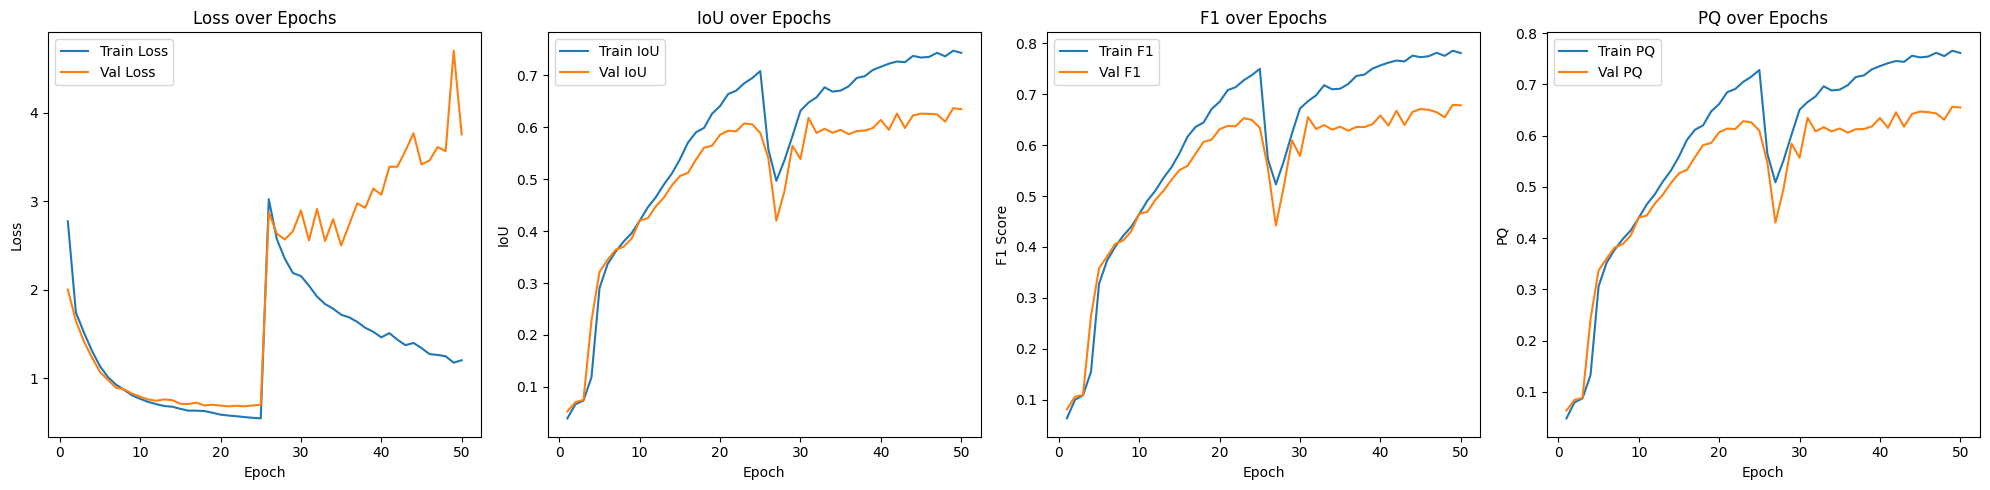

Saved training metrics to training_metrics.csv


In [48]:
train(model, criterion, train_dataloader, val_dataloader, device, 
      num_classes=NUM_CLASSES, epochs=25, patience=25)

In [49]:
final_evaluate(model, test_dataloader, criterion, device, "pretrain", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it, f1=0.695, f1_per_class=[0.0176, 0.0092, 0.0055, 0.0103, 0.0228], iou=0.653, loss=0.672, pq=0.672]


Final Test | Loss: 0.6720 | IoU: 0.6530 | F1: 0.6948 | PQ: 0.6723
F1 per class (excluding background): [0.9328104257583618, 0.6878509521484375, 0.5663860440254211, 0.42136481404304504, 0.9586610794067383, 0.8398551940917969]


In [50]:
final_evaluate(model, test_dataloader, criterion, device, "finetune", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 43/43 [02:01<00:00,  2.83s/it, f1=0.681, f1_per_class=[0.0178, 0.0099, 0.0072, 0.0103, 0.0215], iou=0.644, loss=4.36, pq=0.661]


Final Test | Loss: 4.3606 | IoU: 0.6441 | F1: 0.6815 | PQ: 0.6614
F1 per class (excluding background): [0.9362673759460449, 0.6725666522979736, 0.5483577847480774, 0.39059701561927795, 0.9586610794067383, 0.8372827768325806]


In [51]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_validation_samples(model, dataloader, device, num_classes=6, num_samples=10):
    model.eval()
    samples_shown = 0

    for image, mask, h_grads, v_grads in dataloader:
        image = image.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True).long()
        h_grads = h_grads.to(device, non_blocking=True)
        v_grads = v_grads.to(device, non_blocking=True)
        

        np_logits, hv_logits, nc_logits, _, _ = model(image)
        np_pred = torch.argmax(np_logits, dim=1)
        nc_pred = torch.argmax(nc_logits, dim=1)

        postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        
        B = image.size(0)
        for i in range(B):
            if samples_shown >= num_samples:
                return

            fig, axes = plt.subplots(1, 7, figsize=(21, 4))

            # Input image
            axes[0].imshow(image[i].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Ground truth mask
            axes[1].imshow(mask[i].cpu().numpy(), cmap="jet")
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Predicted mask
            axes[2].imshow(nc_pred[i].cpu().numpy(), cmap="jet")
            axes[2].set_title("Prediction")
            axes[2].axis('off')

            # Horizontal gradient
            axes[3].imshow(hv_logits[i, 0:1,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[3].set_title("HoVer Horizontal")
            axes[3].axis('off')

            # Vertical gradient
            axes[4].imshow(hv_logits[i, 1:2,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[4].set_title("HoVer Vertical")
            axes[4].axis('off')

            axes[5].imshow(np_pred[i].cpu().squeeze().numpy(), cmap='gray')
            axes[5].set_title("Binary Segmentation")
            axes[5].axis('off')

            axes[6].imshow(postprocessed_pred[i].cpu().squeeze().numpy(), cmap="jet")
            axes[6].set_title("Post Processed")
            axes[6].axis('off')

            plt.tight_layout()
            plt.show()

            samples_shown += 1

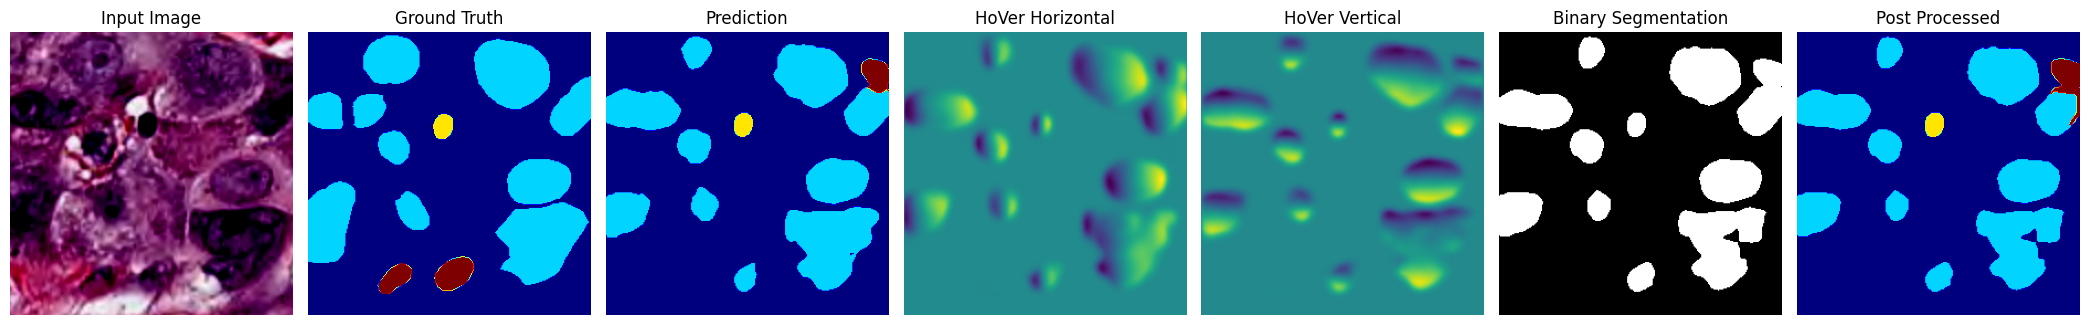

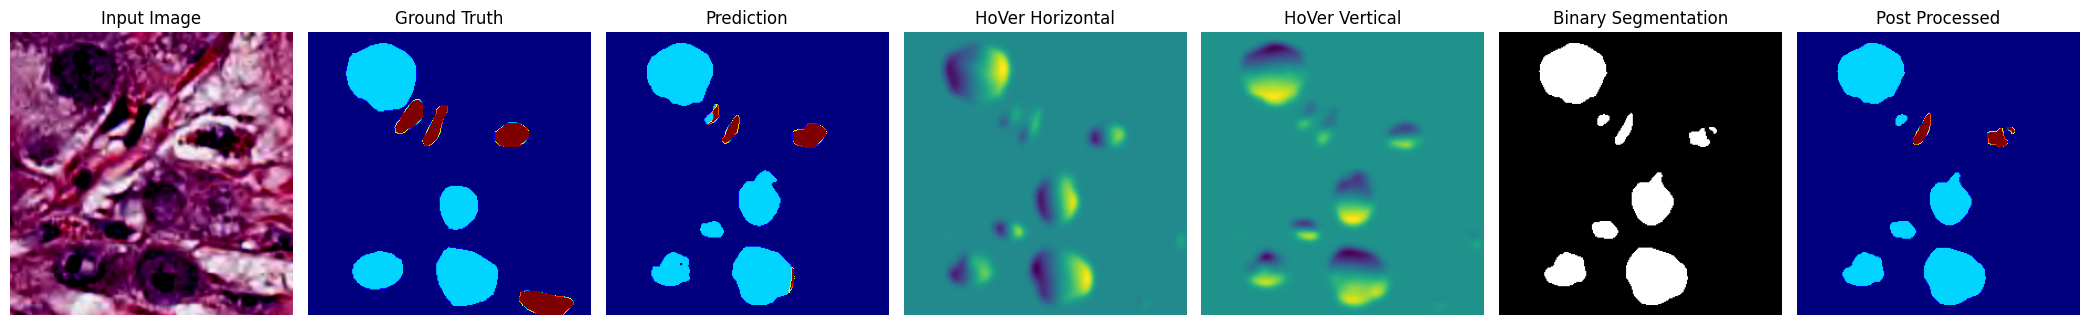

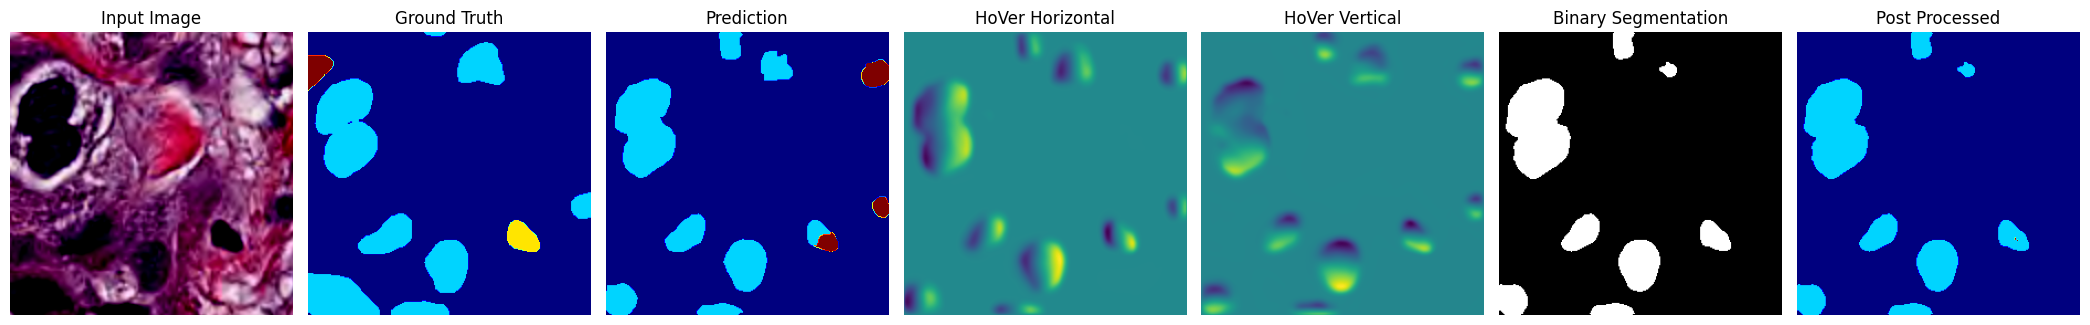

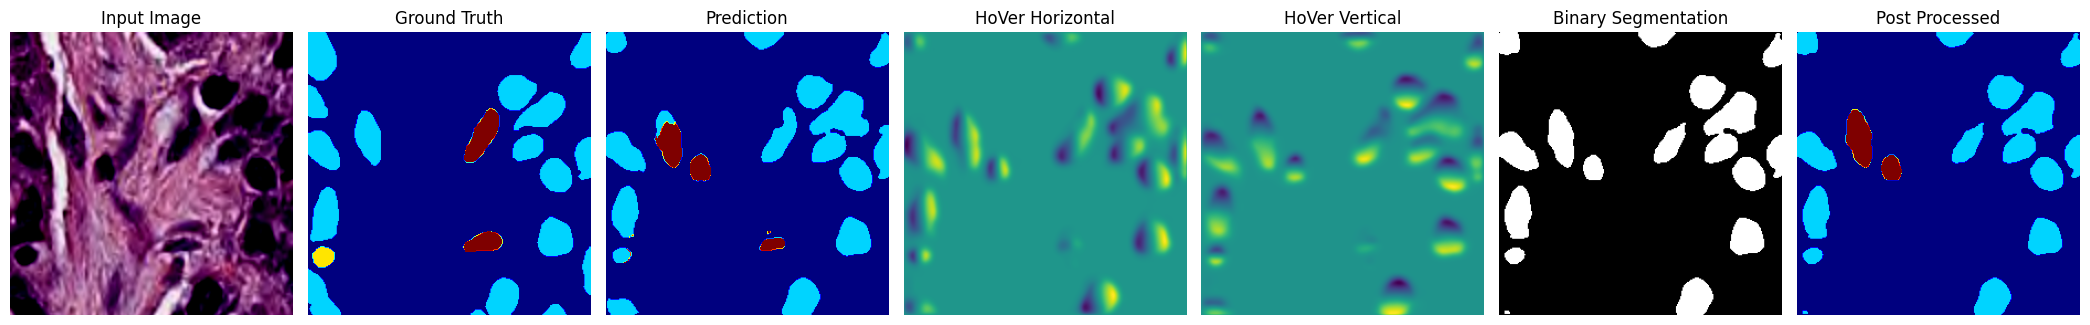

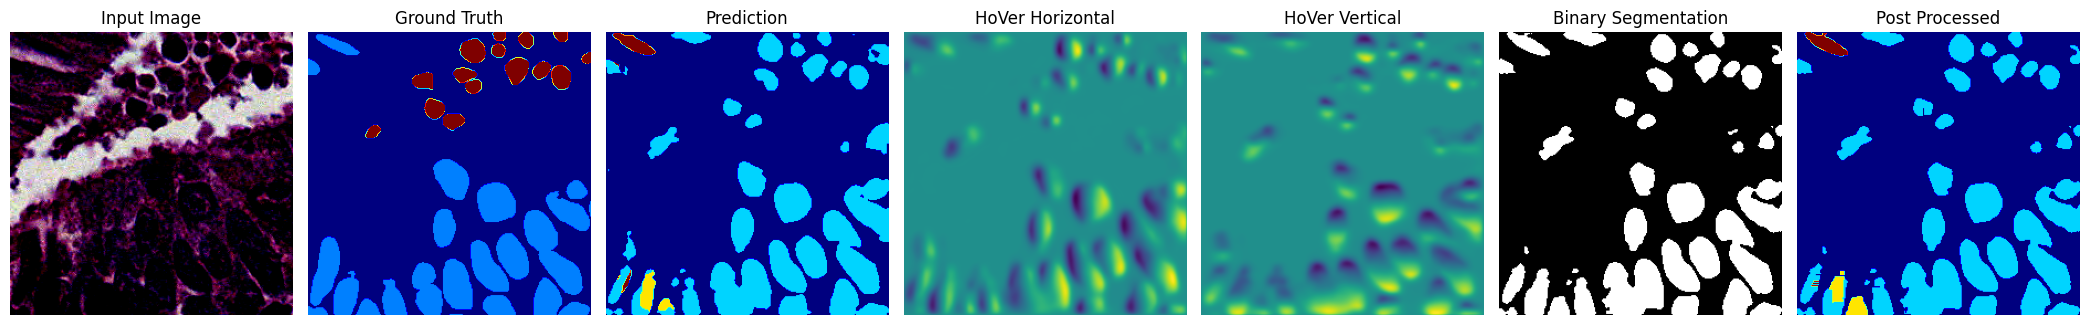

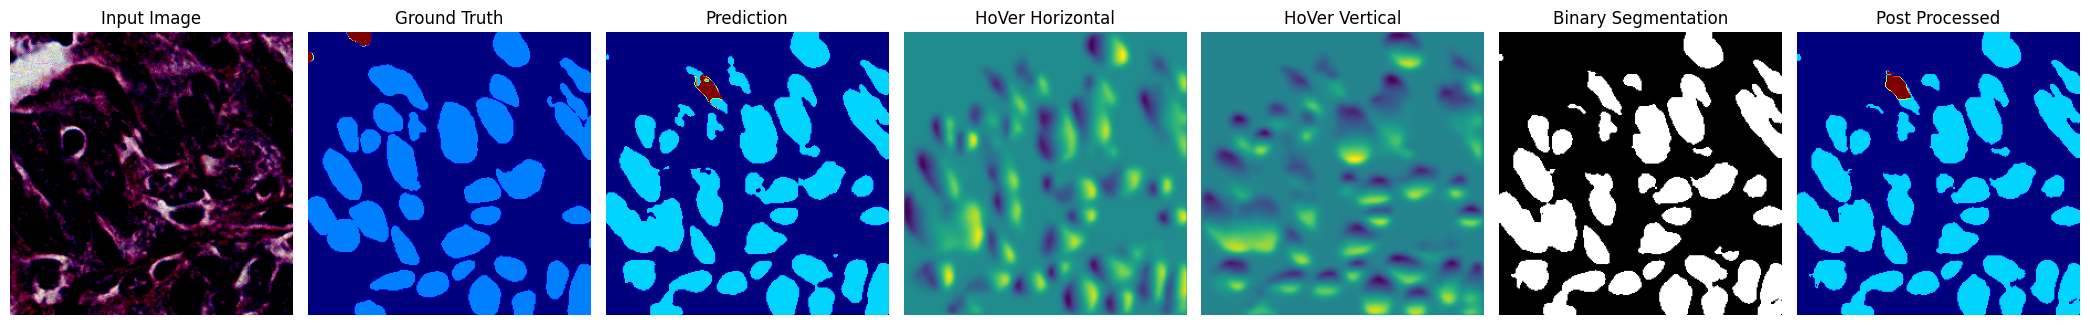

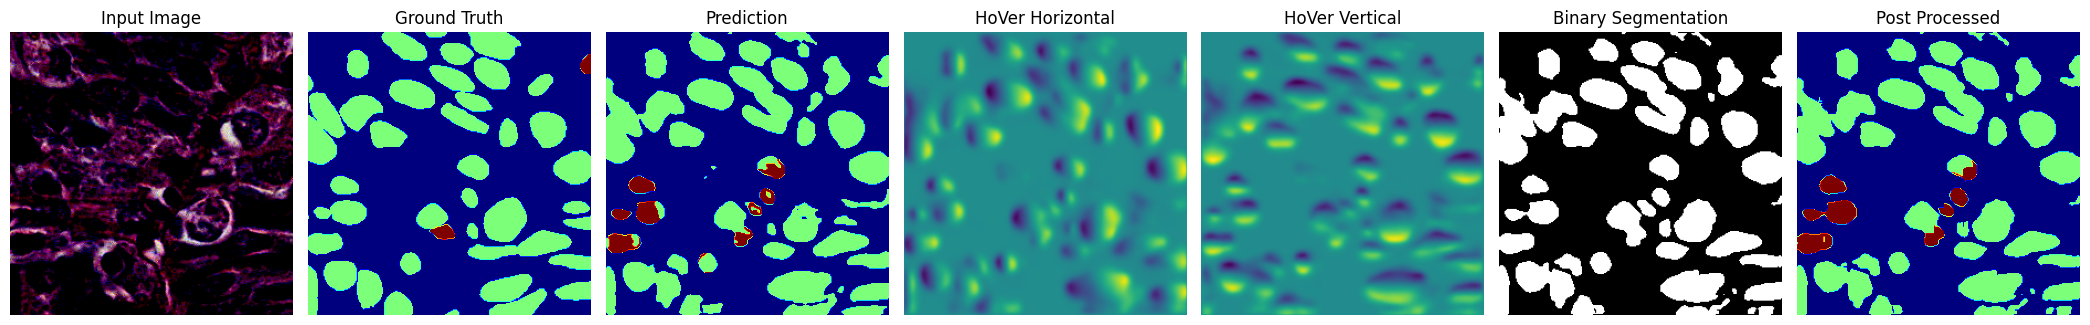

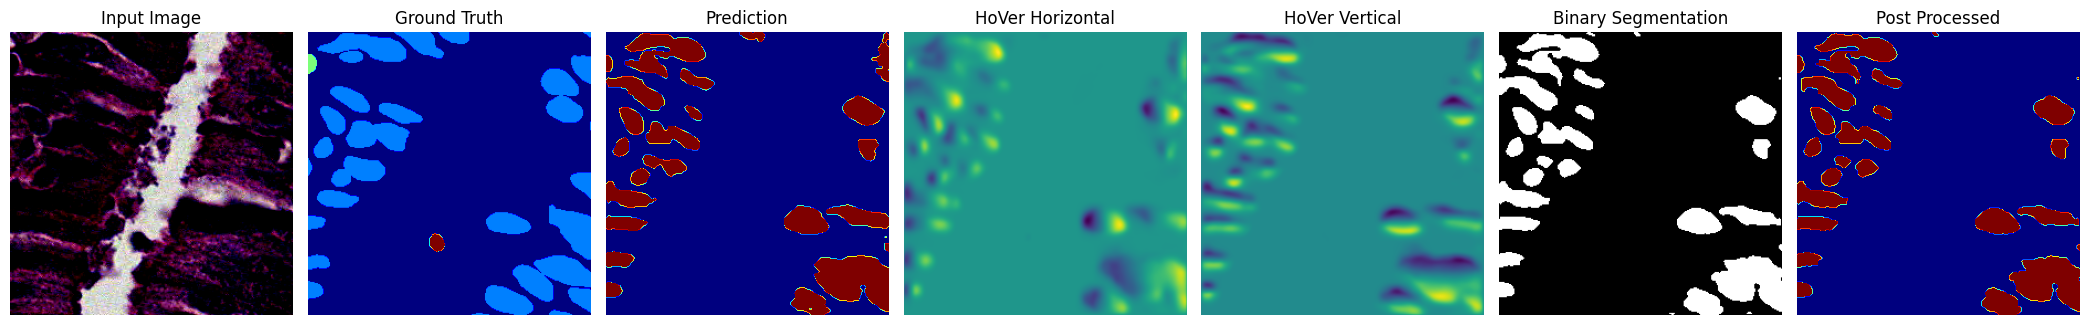

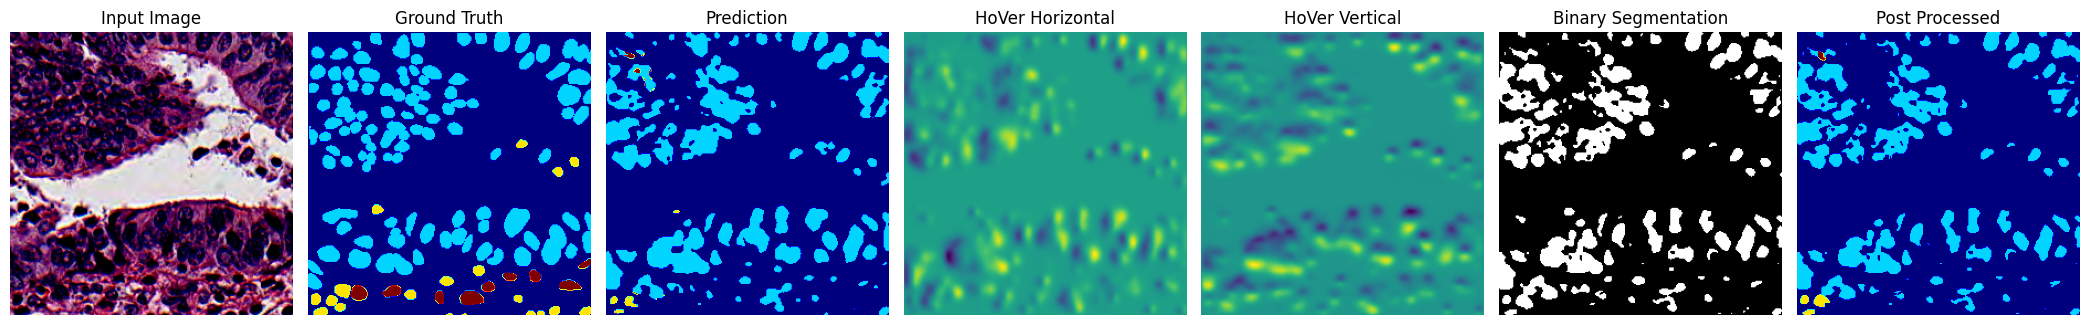

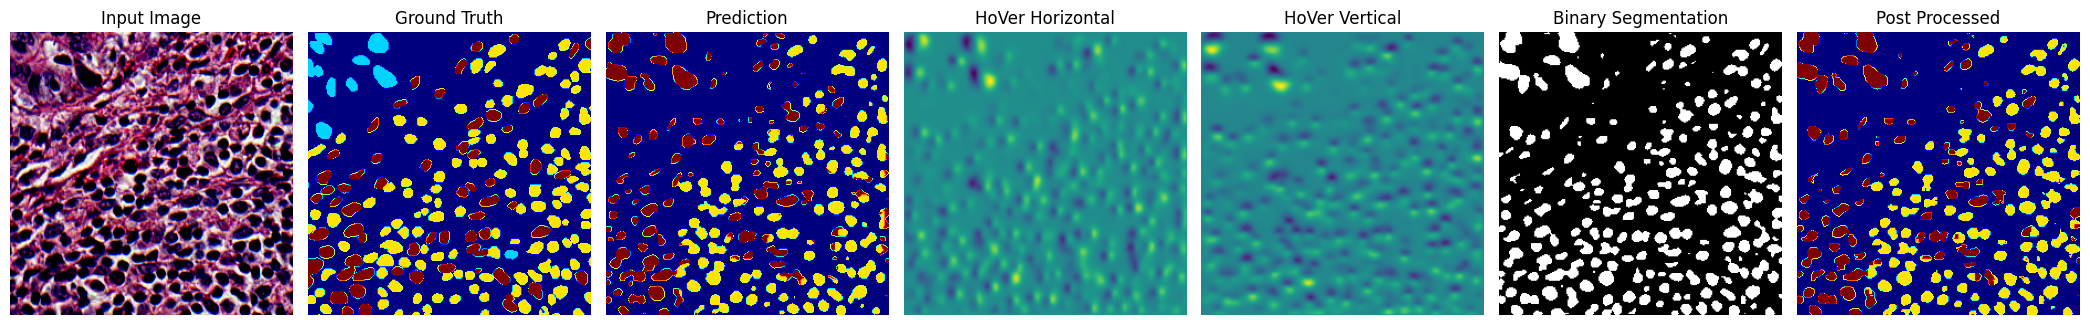

In [52]:
plot_validation_samples(model, test_dataloader, device, num_classes=NUM_CLASSES, num_samples=10)